## Import Libary and requirement


In [31]:
import io
import numpy as np
import os
import tensorflow_hub as hub
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from PIL import Image

## Preparation Data

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
dataset_path = '/content/drive/MyDrive/dataset_CulturLens'

In [34]:
penjor_dir = os.path.join(dataset_path, 'Penjor')
Canang_dir = os.path.join(dataset_path, 'Canang')
Pelinggih_dir = os.path.join(dataset_path, 'Pelinggih')
Pelangkiran_dir = os.path.join(dataset_path, 'Pelangkiran')
Gebogan_dir = os.path.join(dataset_path, 'Gebogan')
BantenSaiban_dir = os.path.join(dataset_path, 'banten_saiban')
kain_Poleng_dir = os.path.join(dataset_path, 'kain poleng')

In [35]:
print(f'total penjor images: {len(os.listdir(penjor_dir))}')
print(f'total Canang images: {len(os.listdir(Canang_dir))}')
print(f'total Pelinggih images: {len(os.listdir(Pelinggih_dir))}')
print(f'total Pelangkiran images: {len(os.listdir(Pelangkiran_dir))}')
print(f'total Gebogan images: {len(os.listdir(Gebogan_dir))}')
print(f'total BantenSaiban images: {len(os.listdir(BantenSaiban_dir))}')
print(f'total Kain Poleng images: {len(os.listdir(kain_Poleng_dir))}')

total penjor images: 209
total Canang images: 204
total Pelinggih images: 200
total Pelangkiran images: 229
total Gebogan images: 211
total BantenSaiban images: 207
total Kain Poleng images: 201


# Augmentasi Data

In [36]:
image_size = (150, 150)  # Resize images to this size
batch_size = 32         # Number of images to process at a time

datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values to [0, 1]
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shearing
    zoom_range=0.2,           # Zooming
    horizontal_flip=True,     # Flip images horizontally
    validation_split=0.2      # Split data into training and validation sets
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' for two classes
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1171 images belonging to 7 classes.
Found 288 images belonging to 7 classes.


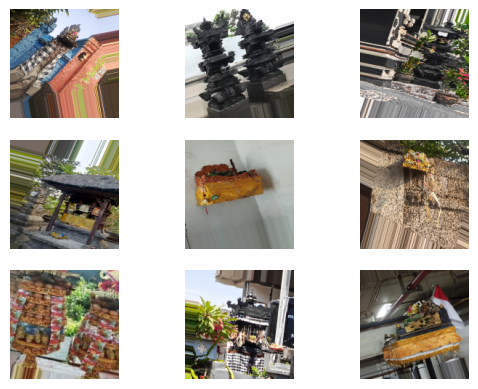

In [37]:


# Get a batch of training images
images, labels = next(train_generator)

# Plot a few images
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [38]:
# Load a pre-trained MobileNetV2 model (excluding the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model's layers so they are not updated during training
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

<ipython-input-38-9d37ddc1c8cf>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [39]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5818 - loss: 1.2394 - val_accuracy: 0.9028 - val_loss: 0.2565
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9259 - loss: 0.2261 - val_accuracy: 0.9653 - val_loss: 0.1541
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9610 - loss: 0.1330 - val_accuracy: 0.9236 - val_loss: 0.2015
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9313 - loss: 0.2038 - val_accuracy: 0.9306 - val_loss: 0.1862
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9462 - loss: 0.1427 - val_accuracy: 0.9549 - val_loss: 0.1684
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9665 - loss: 0.0954 - val_accuracy: 0.9514 - val_loss: 0.1487
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9708 - loss: 0.0835 - val_accuracy: 0.9167 - val_loss: 0.2596
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9486 - loss: 0.1294 - val_accuracy: 0.9236 - val_loss: 0.2232

Text(0.5, 1.0, 'Training and validation loss')

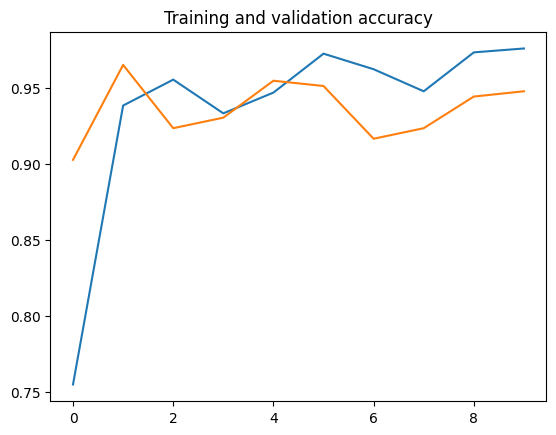

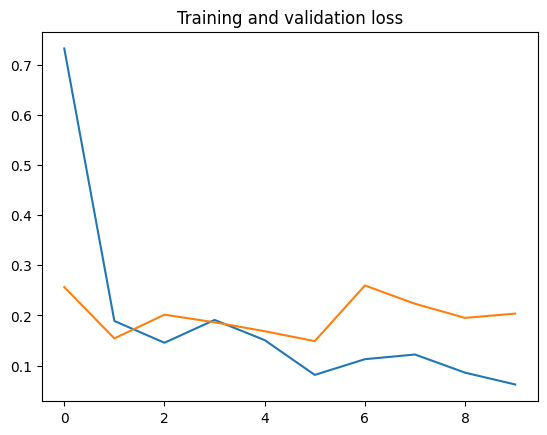

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [42]:

def preprocess_image(image_path, target_size):

    # Muat gambar dan ubah ukurannya ke ukuran target
    img = load_img(image_path, target_size=target_size)
    # Konversi ke array numpy
    img_array = img_to_array(img)
    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    # Normalisasi piksel ke [0, 1]
    img_array /= 255.0
    return img_array

## Save Model

In [43]:
os.makedirs("/content/Save_model", exist_ok=True)

In [44]:
#Save model format HDF5
model.save("/content/Save_model/model.h5")

In [45]:
# Saved Model Format Json
model_json = model.to_json()
with open("/content/Save_model/model.json", "w") as json_file:
    json_file.write(model_json)
# Changed the filename to include .weights before .h5
model.save_weights("/content/Save_model/model_weights.weights.h5")

model.save("/content/Save_model/saved_model_file.keras")



In [46]:
!zip -r /content/Save_model.zip /content/Save_model

updating: content/Save_model/ (stored 0%)
updating: content/Save_model/model.h5 (deflated 11%)
updating: content/Save_model/model.json (deflated 97%)
updating: content/Save_model/model_weights.weights.h5 (deflated 10%)
updating: content/Save_model/saved_model_file.keras (deflated 11%)


In [47]:
from google.colab import files
files.download("/content/Save_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing Model


In [48]:
#Define a dictionary of custom objects:
custom_objects = {'KerasLayer': hub.KerasLayer}  # Use hub.KerasLayer

#Load the model with custom objects:
model = tf.keras.models.load_model('/content/Save_model/model.h5', custom_objects=custom_objects)

#Labeling Class
class_indices = {
    0: 'Canang',
    1: 'Gebogan',
    2: 'Pelangkiran',
    3: 'Pelinggih',
    4: 'Penjor',
    5: 'Banten Saiban',
    6: 'kain poleng'
}

In [49]:
from google.colab import files

#Unggah file gambar
uploaded = files.upload()

#Ambil path file yang diunggah
for file_name in uploaded.keys():
    print(f"File diunggah: {file_name}")
    image_path = file_name
    image = preprocess_image(image_path, target_size=(150, 150))
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions[0])
    predicted_label = class_indices[predicted_class]
    print(f"Gambar yang diunggah diprediksi sebagai: {predicted_label}")

Saving Screenshot 2024-11-23 190705.png to Screenshot 2024-11-23 190705.png
File diunggah: Screenshot 2024-11-23 190705.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Gambar yang diunggah diprediksi sebagai: kain poleng
